# 1. Data Preparing

In [10]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math
from sklearn.metrics import mean_squared_error

In [11]:
data = pd.read_excel("Monthly Inflation Rate.xlsx",index_col='Time', parse_dates=['Time'])
df=pd.DataFrame(data)
df.head()

,Inflation Rate
Time,
1999年1月,-2.42
1999年2月,-2.83
1999年3月,-3.24
1999年4月,-2.98
1999年5月,-3.06


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 1999年1月 to 2023年9月
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Inflation Rate  297 non-null    float64
dtypes: float64(1)
memory usage: 4.6+ KB


In [13]:
# No NAN value

In [14]:
df.describe()

,Inflation Rate
count,297.000000
mean,2.329394
std,3.207226
min,-3.650000
25%,-0.200000
50%,2.550000
75%,5.070000
max,9.490000


## 1.1 Check the Stationarity

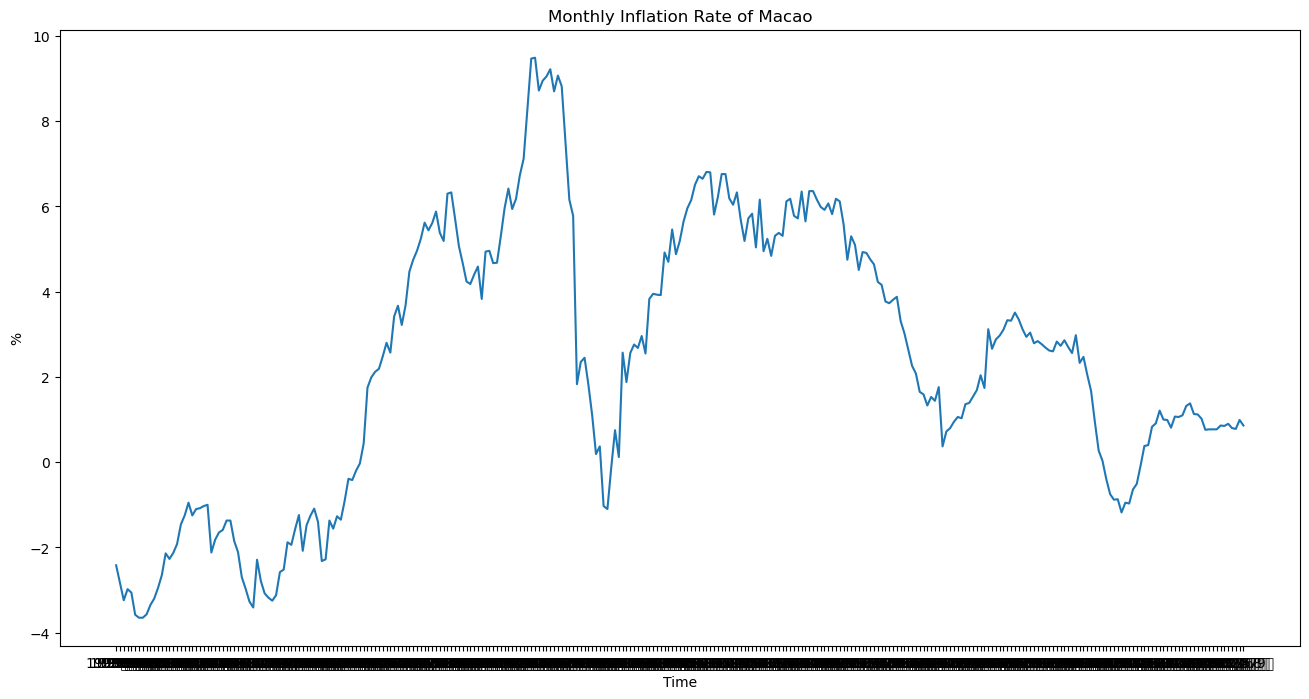

In [15]:
plt.figure(figsize=(16,8))
plt.title('Monthly Inflation Rate of Macao')
plt.xlabel('Time')
plt.ylabel('%')
plt.plot(df);

In [16]:
# Apparently not stationary. A slightly increasing trend.

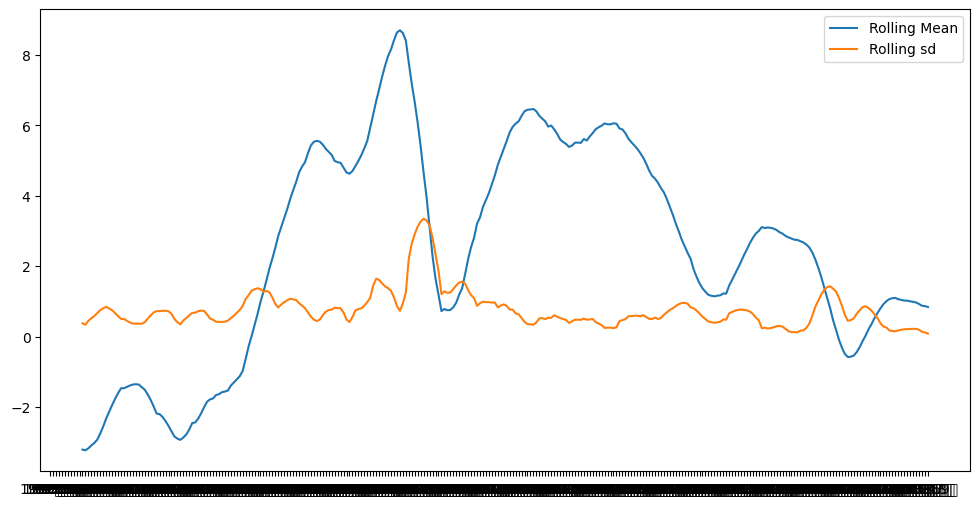

In [17]:
# Check Stationarity

plt.figure(figsize=(12,6))
plt.plot(df.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(df.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

In [18]:
# The mean is not constant, therefore the time series is not stationary.

# We also can run ADF test to test the stationarity

In [19]:
from statsmodels.tsa.stattools import adfuller

adftest0 = adfuller(df)
adf_results0= pd.Series(adftest0[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adftest0[4].items():
    adf_results0['Critical Value (%s)'%key] = value
adf_results0

Test Statistic                  -1.807183
p-value                          0.376902
#Lags Used                      12.000000
Number of Observations Used    284.000000
Critical Value (1%)             -3.453587
Critical Value (5%)             -2.871771
Critical Value (10%)            -2.572222
dtype: float64

In [20]:
# Therefore, as p-value>0.05 and test statistic is larger than Critical Value (5%), so fail to reject the null hypothesis i.e. the time seires is non-stationary

## 1.2 Transform to a stationary time series

In [21]:
# Remove the trend by first order differencing 

df_diff = df.diff().dropna()

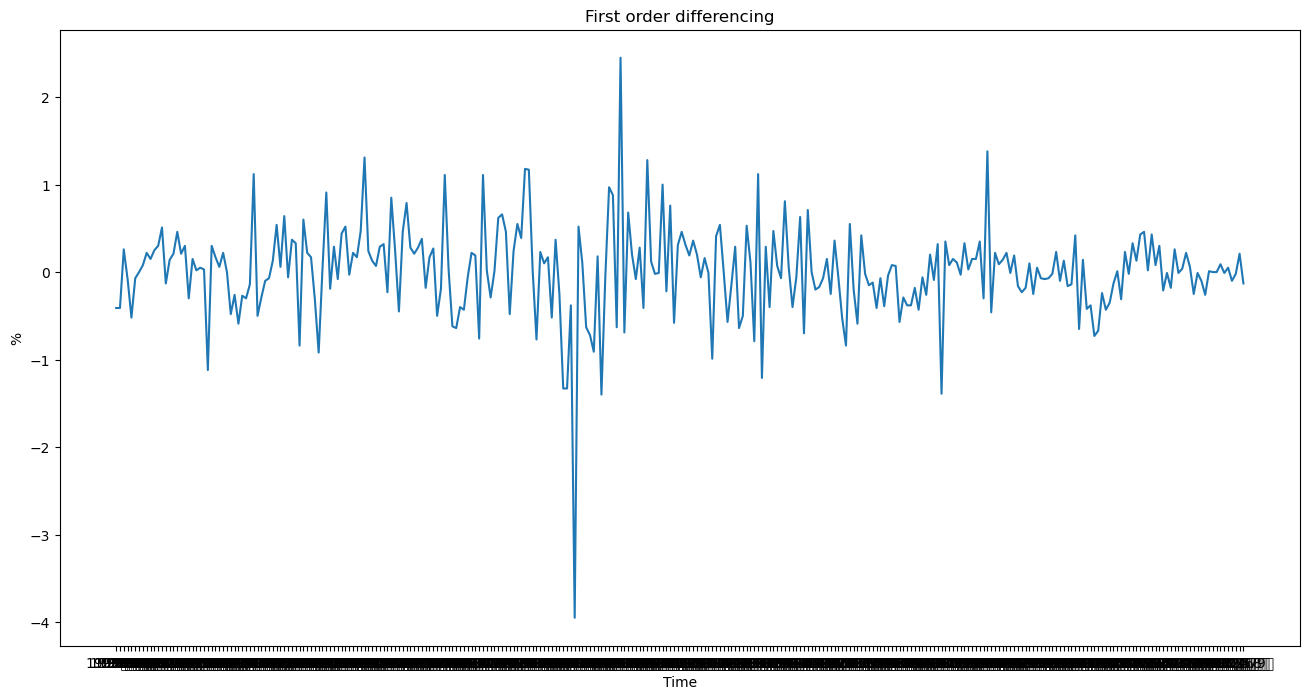

In [22]:
plt.figure(figsize=(16,8))
plt.title('First order differencing')
plt.xlabel('Time')
plt.ylabel('%')
plt.plot(df_diff);

In [23]:
# Apply ADF test again

adftest = adfuller(df_diff)
adf_results= pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in adftest[4].items():
    adf_results['Critical Value (%s)'%key] = value
adf_results

Test Statistic                -7.027643e+00
p-value                        6.303815e-10
#Lags Used                     1.100000e+01
Number of Observations Used    2.840000e+02
Critical Value (1%)           -3.453587e+00
Critical Value (5%)           -2.871771e+00
Critical Value (10%)          -2.572222e+00
dtype: float64

In [24]:
# Therefore, as p-value<0.05 and the test statistic is less than Critical Value (5%), so reject the null hypothesis i.e. the first order differenced time seires is stationary

## 1.4 Decomposition

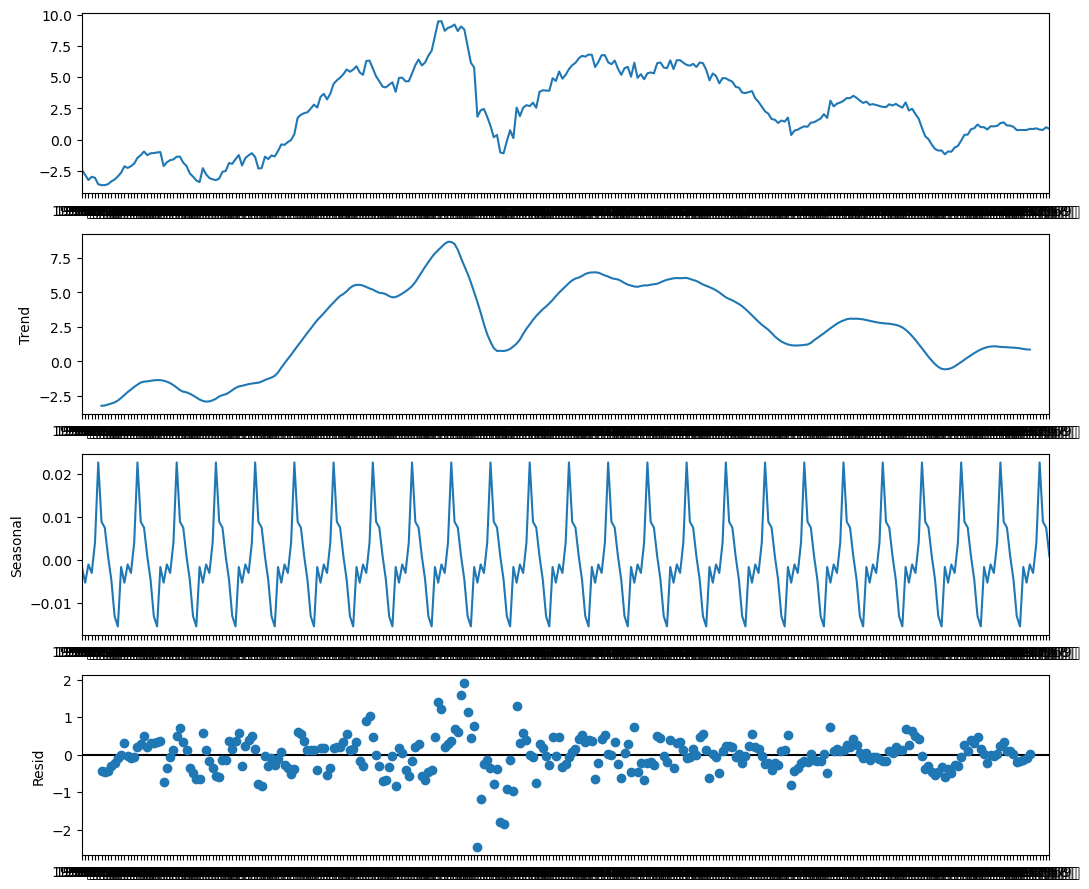

In [25]:
# Decomposition: Check the trend, seasonality and residuals at once

from pylab import rcParams

rcParams['figure.figsize'] = 11, 9
decomposed = sm.tsa.seasonal_decompose(df,period=12) 
figure = decomposed.plot() #This line is creating a plot of the decomposed time series. The plot will have four subplots: the original time series, the trend component, the seasonal component, and the residual component.
plt.show()

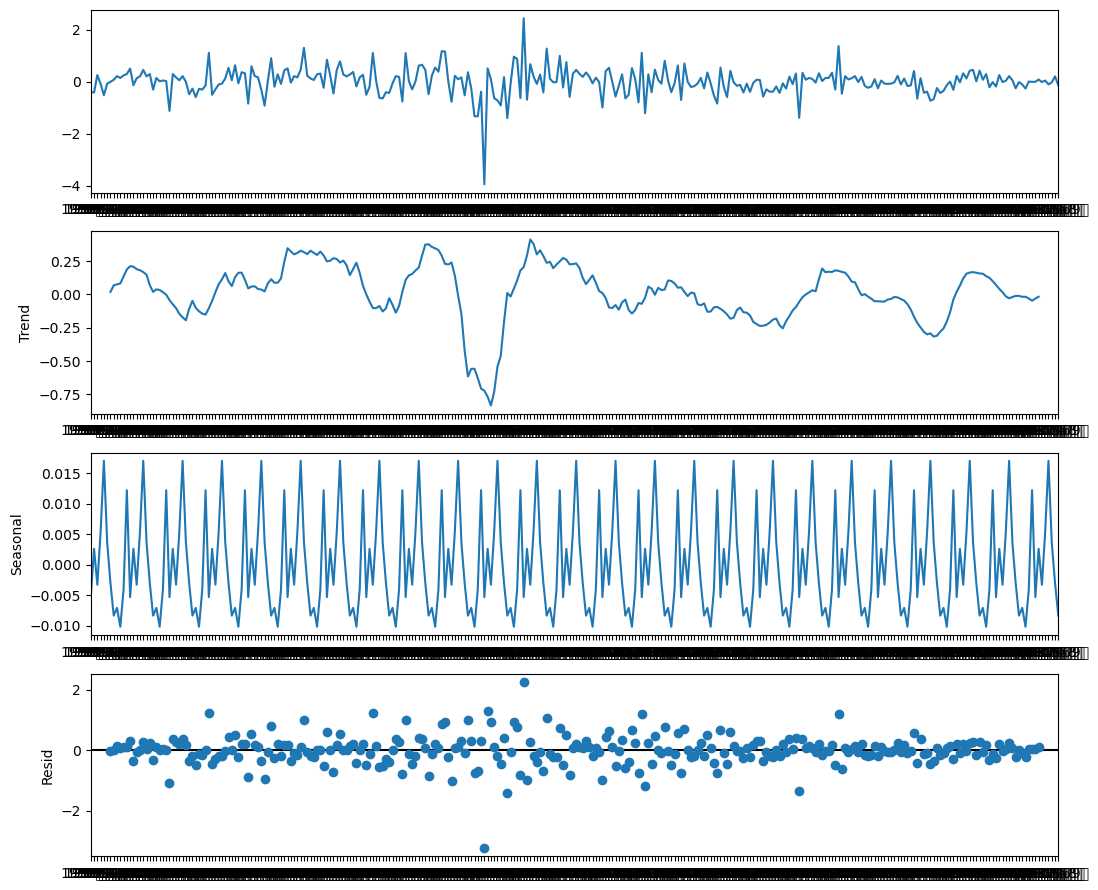

In [26]:
# Decompose the differenced df

rcParams['figure.figsize'] = 11, 9
diff_decomposed = sm.tsa.seasonal_decompose(df_diff,period=12) 
figure = diff_decomposed.plot() #This line is creating a plot of the decomposed time series. The plot will have four subplots: the original time series, the trend component, the seasonal component, and the residual component.
plt.show()

## 1.3 Split training and testing sets

In [27]:
split_point = int(len(df) * 0.8)

train = df.iloc[:split_point]
test = df.iloc[split_point:]

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 237 entries, 1999年1月 to 2018年9月
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Inflation Rate  237 non-null    float64
dtypes: float64(1)
memory usage: 3.7+ KB


In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 2018年10月 to 2023年9月
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Inflation Rate  60 non-null     float64
dtypes: float64(1)
memory usage: 960.0+ bytes


# 2. Select the appropriate model

## Plot ACF and PACF

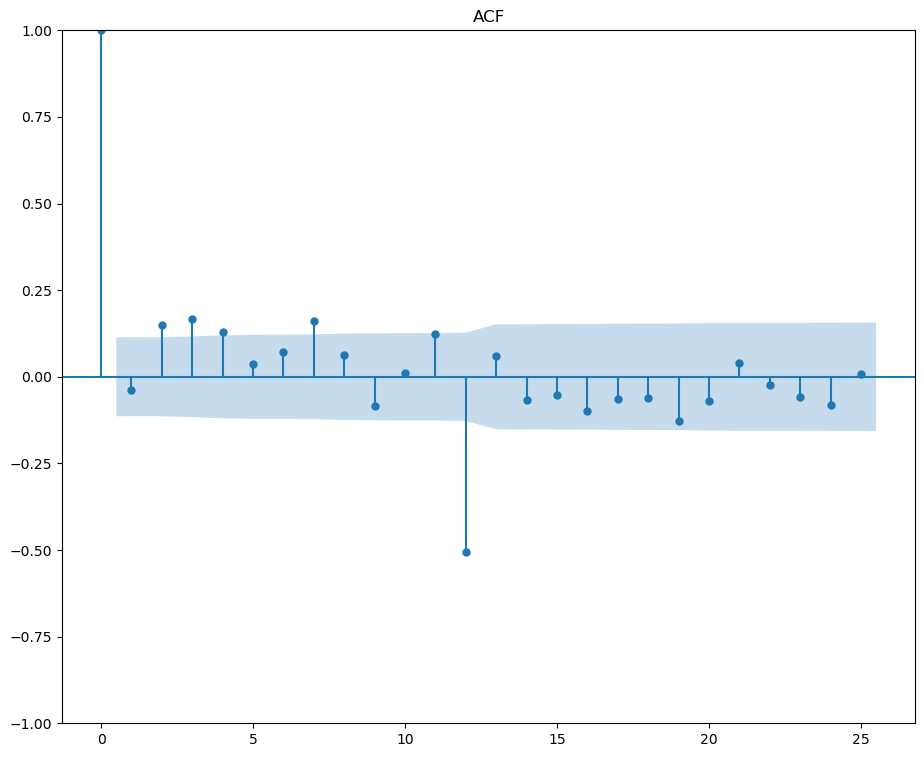

In [30]:
plot_acf(df_diff,lags=25,title="ACF")
plt.show()

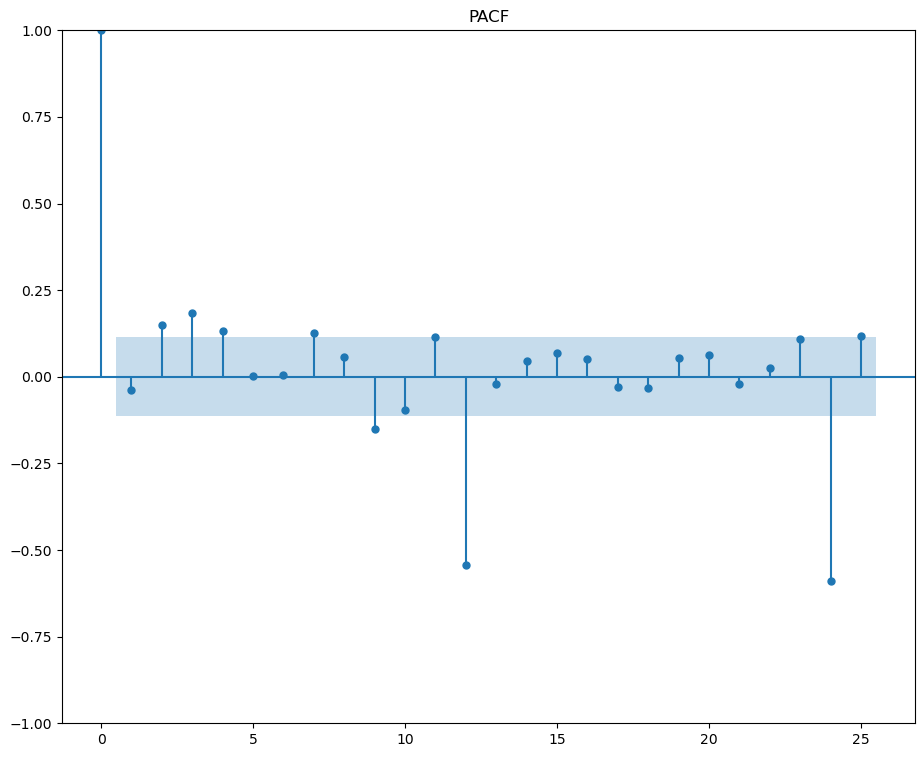

In [31]:
plot_pacf(df_diff,lags=25,title="PACF")
plt.show()

In [32]:
# ACF and PACF plots suggest a SARMA model

## Try ARMA

In [33]:
# Create empty list to store search results
order_aic_bic=[]

for p in range(0, 3):
 
    for q in range(0, 3):
      	# create and fit ARMA(p,q) model
        model = SARIMAX(df_diff, order=(p,0,q))
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p, q, results.aic, results.bic))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.84286D-01    |proj g|=  3.55826D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     16      1     0     0   3.557D-05   7.843D-01
  F =  0.78428631686332240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.8

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.80095D-01    |proj g|=  6.97283D-02

At iterate   10    f=  7.74626D-01    |proj g|=  7.40675D-03

At iterate   15    f=  7.73167D-01    |proj g|=  4.66104D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     20      1     0     0   4.789D-06   7.732D-01
  F =  0.77316706508086297     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.49117D-01    |proj g|=  4.51463D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.47907D-01    |proj g|=  3.75922D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   3.759D-08   7.479D-01
  F =  0.74790721624119227     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72426D-01    |proj g|=  4.91215D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.52254D-01    |proj g|=  6.79184D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   1.468D-06   7.522D-01
  F =  0.75222724264320628     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.53378D-01    |proj g|=  3.19718D-02

At iterate    5    f=  7.49451D-01    |proj g|=  4.38581D-02

At iterate   10    f=  7.47987D-01    |proj g|=  1.83764D-02

At iter

In [34]:
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','q','AIC','BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values(by='AIC', ascending=True))

# Print order_df in order of increasing BIC
print(order_df.sort_values(by='BIC', ascending=True))

   p  q         AIC         BIC
8  2  2  425.638860  444.090658
5  1  2  450.761072  465.522510
7  2  1  453.318528  468.079965
2  0  2  462.967948  474.039026
6  2  0  463.273363  474.344442
4  1  1  463.714903  474.785981
0  0  0  466.297500  469.987859
3  1  0  467.879058  475.259776
1  0  1  467.977703  475.358422
   p  q         AIC         BIC
8  2  2  425.638860  444.090658
5  1  2  450.761072  465.522510
7  2  1  453.318528  468.079965
0  0  0  466.297500  469.987859
2  0  2  462.967948  474.039026
6  2  0  463.273363  474.344442
4  1  1  463.714903  474.785981
3  1  0  467.879058  475.259776
1  0  1  467.977703  475.358422


In [35]:
model = sm.tsa.ARIMA(train,order=(2,1,2))
arma = model.fit()
print(arma.summary())

                               SARIMAX Results                                
Dep. Variable:         Inflation Rate   No. Observations:                  237
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -186.500
Date:                Sun, 26 Nov 2023   AIC                            383.000
Time:                        17:47:58   BIC                            400.319
Sample:                             0   HQIC                           389.981
                                - 237                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5397      0.062     25.032      0.000       1.419       1.660
ar.L2         -0.6967      0.066    -10.506      0.000      -0.827      -0.567
ma.L1         -1.7376      0.036    -47.860      0.0

In [36]:
# As the p-value for Ljung-Box test is 0.98>0.05，so we can reject the null hypothesis that there is autocorrelation.

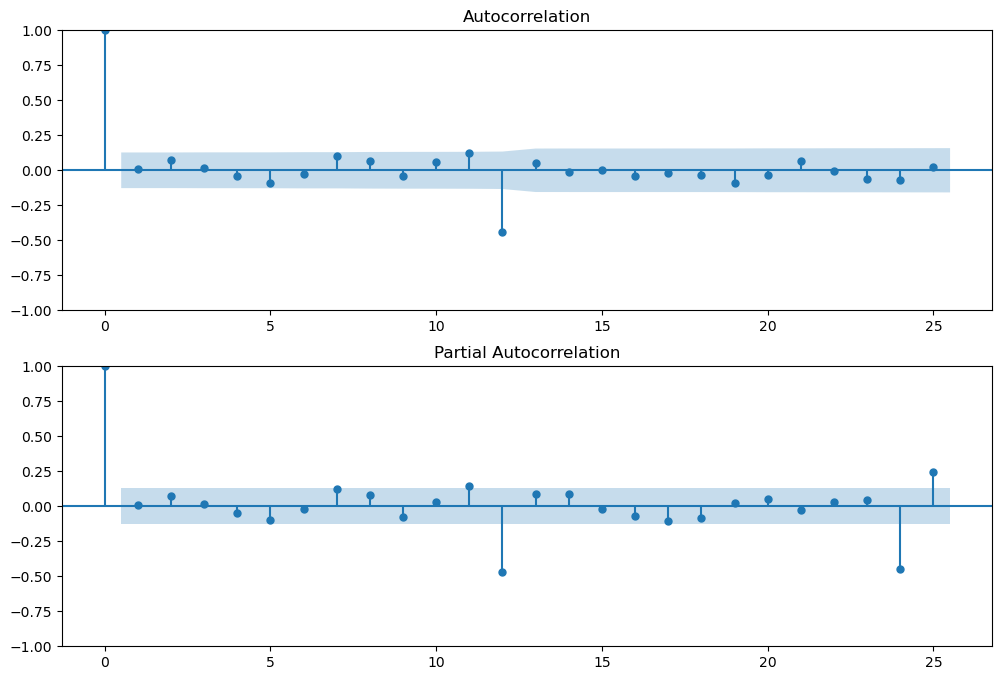

In [37]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arma.resid, lags=25, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arma.resid, lags=25, ax=ax2)

## SARIMA

### Determin (p,d,q),(P,D,Q)s

In [38]:
import itertools

p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Specify to use AIC for model selection
best_aic = float('inf')
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Grid search
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
            model_fit = model.fit(disp=False)
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = model_fit
        except:
            continue

print(f'Best SARIMA model: {best_pdq}x{best_seasonal_pdq} with AIC: {best_aic}')


Best SARIMA model: (1, 1, 1)x(1, 0, 1, 12) with AIC: 240.43689083538084


In [39]:
model_2 = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
sarima = model_2.fit(disp=False)
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     Inflation Rate   No. Observations:                  237
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -115.218
Date:                            Sun, 26 Nov 2023   AIC                            240.437
Time:                                    17:48:18   BIC                            257.756
Sample:                                         0   HQIC                           247.418
                                            - 237                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9927      0.021     46.352      0.000       0.951       1.035
ma.L1         -0.8395      0.034   

In [40]:
# p-value for Ljung-Box test is larger than 0.05, fail to reject H0, so pass the Ljung-Box test.

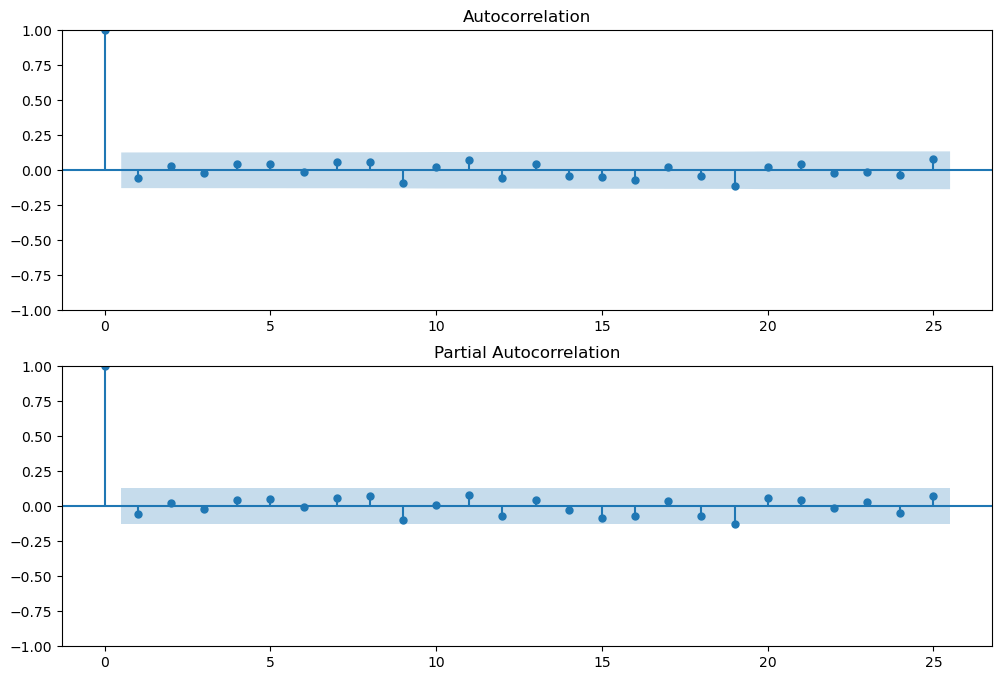

In [41]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima.resid, lags=25, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima.resid, lags=25, ax=ax2)

In [42]:
lb_test = sm.stats.acorr_ljungbox(sarima.resid, lags=10)
lb_test

,lb_stat,lb_pvalue
1,0.816881,0.366094
2,1.033186,0.596550
3,1.131935,0.769371
4,1.685327,0.793381
5,2.201305,0.820647
6,2.227857,0.897595
7,3.107843,0.874850
8,4.017792,0.855515
9,6.009741,0.738943
10,6.114478,0.805555


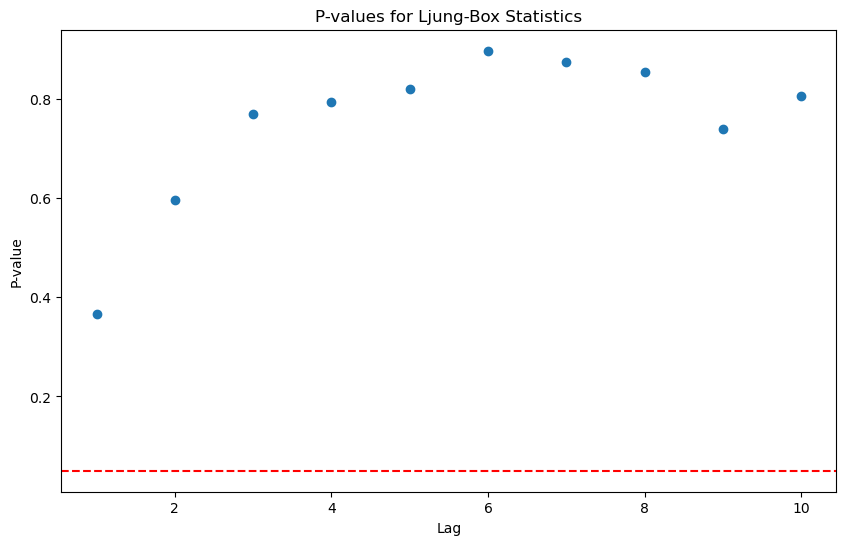

In [43]:
#lb_test = sm.stats.acorr_ljungbox(sarima.resid, lags=10)

# Extract the p-values
p_values = lb_test['lb_pvalue']

# Plot the p-values
plt.figure(figsize=(10,6))
plt.plot(p_values, 'o')
plt.axhline(y=0.05, linestyle='--', color='red')  
plt.title('P-values for Ljung-Box Statistics')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.show()

# 3. Predict

## 3.1 Simple Forecast

In [44]:
predictions=sarima.forecast(60)

In [45]:
mean_squared_error(test, predictions)

3.324261857149052

In [46]:
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.823


In [47]:
sf = pd.read_excel("Monthly Inflation Rate.xlsx",index_col='Time')
sf.head()

,Inflation Rate
Time,
1999年1月,-2.42
1999年2月,-2.83
1999年3月,-3.24
1999年4月,-2.98
1999年5月,-3.06


In [48]:
sf_plot=sf[-60:]

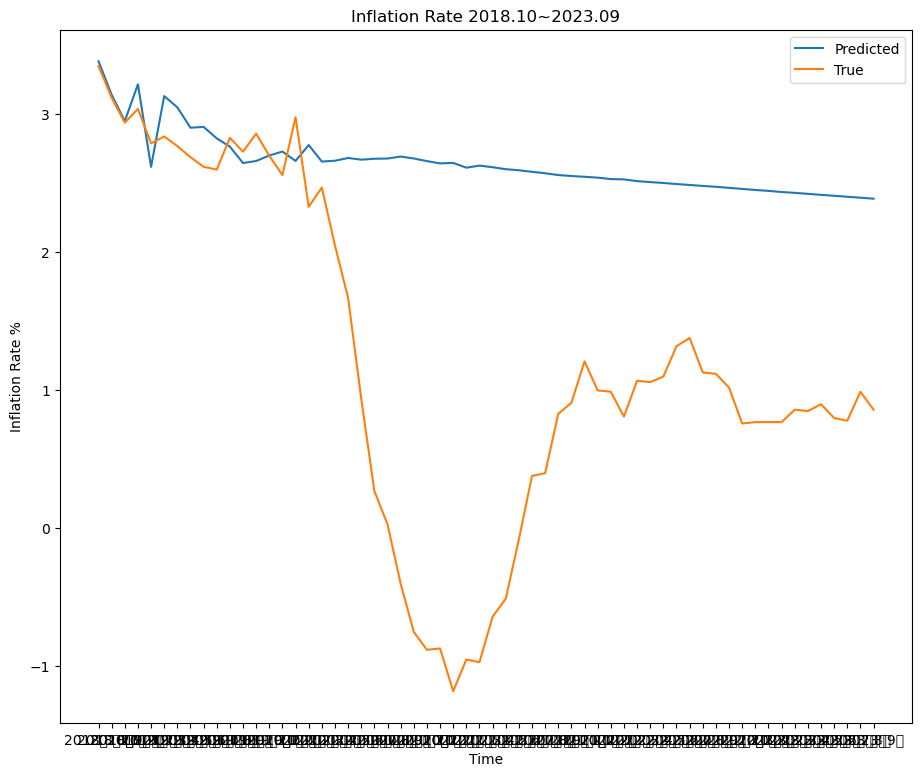

In [51]:
plt.plot(predictions.values, label='Predicted')
plt.plot(sf_plot,label='True')
plt.xlabel('Time')
plt.ylabel('Inflation Rate %')
plt.title('Inflation Rate 2018.10~2023.09')
plt.legend()
plt.show()

## 3.2 Rolling forecast

In [52]:
rolling_predictions = []
test_size = 60

for i in range(test_size):
    train = df[:-(test_size-i)]  #[ :i-60]
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12))
    model_fit = model.fit()
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(pred)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.51721D-01    |proj g|=  4.51129D-01

At iterate    5    f=  5.55357D-01    |proj g|=  6.35564D-02

At iterate   10    f=  4.94654D-01    |proj g|=  9.20203D-02

At iterate   15    f=  4.88083D-01    |proj g|=  1.37901D-02

At iterate   20    f=  4.86172D-01    |proj g|=  2.37305D-03

At iterate   25    f=  4.86154D-01    |proj g|=  2.28122D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  5.54017D-01    |proj g|=  6.23911D-02

At iterate   10    f=  4.92234D-01    |proj g|=  5.99605D-02

At iterate   15    f=  4.84760D-01    |proj g|=  7.13430D-03

At iterate   20    f=  4.83850D-01    |proj g|=  8.97748D-04

At iterate   25    f=  4.83844D-01    |proj g|=  2.00319D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   2.003D-05   4.838D-01
  F =  0.48384373687329296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47853D-01    |proj g|=  4.53127D-01

At iterate    5    f=  5.49983D-01    |proj g|=  6.21470D-02

At iterate   10    f=  4.89590D-01    |proj g|=  5.50431D-02

At iterate   15    f=  4.82496D-01    |proj g|=  8.59465D-03

At iterate   20    f=  4.81524D-01    |proj g|=  1.09395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     30      1     0     0   9.834D-05   4.815D-01
  F =  0.48151024899862382     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  4.86250D-01    |proj g|=  3.93637D-02

At iterate   15    f=  4.79847D-01    |proj g|=  6.50986D-03

At iterate   20    f=  4.79195D-01    |proj g|=  8.03738D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   5.346D-05   4.792D-01
  F =  0.47918828610094505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.42412D-01    |proj g|=  4.59714D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  4.77942D-01    |proj g|=  6.57256D-03

At iterate   20    f=  4.77301D-01    |proj g|=  9.52441D-04

At iterate   25    f=  4.77295D-01    |proj g|=  9.15893D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     32      1     0     0   9.159D-05   4.773D-01
  F =  0.47729511963901805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.40872D-01    |proj g|=  4.58940D-01

At iterate    5    f=  5.43310D-01    |proj g|=  5.98337D-02

At iterate   10    f=  4.84020D-01    |proj g|=  3.07324D-02

At iterate   15    f=  4.77819D-01    |proj g|=  5.93703D-03

At iterate   20    f=  4.77101D-01    |proj g|=  1.26171D-03

At iterate   25    f=  4.77094D-01    |proj g|=  1.45976D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  5.43665D-01    |proj g|=  5.82952D-02

At iterate   10    f=  4.85253D-01    |proj g|=  1.96262D-02

At iterate   15    f=  4.78779D-01    |proj g|=  1.13665D-03

At iterate   20    f=  4.78425D-01    |proj g|=  2.75055D-03

At iterate   25    f=  4.78424D-01    |proj g|=  9.97178D-05

At iterate   30    f=  4.78413D-01    |proj g|=  3.54677D-03

At iterate   35    f=  4.78396D-01    |proj g|=  5.97128D-04

At iterate   40    f=  4.78394D-01    |proj g|=  1.13056D-03

At iterate   45    f=  4.78393D-01    |proj g|=  4.12000D-04

At iterate   50    f=  4.78393D-01    |proj g|=  6.89889D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36205D-01    |proj g|=  4.61831D-01

At iterate    5    f=  5.41515D-01    |proj g|=  5.82151D-02

At iterate   10    f=  4.83193D-01    |proj g|=  1.95619D-02

At iterate   15    f=  4.76588D-01    |proj g|=  4.94577D-03

At iterate   20    f=  4.76191D-01    |proj g|=  3.31501D-03

At iterate   25    f=  4.76189D-01    |proj g|=  6.48065D-05

At iterate   30    f=  4.76176D-01    |proj g|=  2.01466D-03

At iterate   35    f=  4.76160D-01    |proj g|=  5.07937D-04

At iterate   40    f=  4.76157D-01    |proj g|=  8.46314D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   45    f=  4.76157D-01    |proj g|=  3.54009D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     73      1     0     0   3.540D-04   4.762D-01
  F =  0.47615661959315203     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34616D-01    |proj g|=  4.61042D-01

At iterate    5    f=  5.38728D-01    |proj g|=  5.82005D-02

At iterate   10    f=  4.81201D-01    |proj g|=  1.88447D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  5.36241D-01    |proj g|=  5.82499D-02

At iterate   10    f=  4.79162D-01    |proj g|=  1.90760D-02

At iterate   15    f=  4.72329D-01    |proj g|=  1.77413D-02

At iterate   20    f=  4.71877D-01    |proj g|=  5.31284D-04

At iterate   25    f=  4.71872D-01    |proj g|=  2.39182D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   2.392D-05   4.719D-01
  F =  0.47187201828238096     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f=  4.76232D-01    |proj g|=  2.44871D-02

At iterate   15    f=  4.70248D-01    |proj g|=  1.19862D-02

At iterate   20    f=  4.69750D-01    |proj g|=  5.03614D-04

At iterate   25    f=  4.69747D-01    |proj g|=  3.04068D-04

At iterate   30    f=  4.69739D-01    |proj g|=  9.65156D-03

At iterate   35    f=  4.69702D-01    |proj g|=  5.22738D-04

At iterate   40    f=  4.69698D-01    |proj g|=  2.68303D-03

At iterate   45    f=  4.69697D-01    |proj g|=  2.08662D-04

At iterate   50    f=  4.69697D-01    |proj g|=  8.75509D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.28586D-01    |proj g|=  4.64323D-01

At iterate    5    f=  5.32799D-01    |proj g|=  5.79973D-02

At iterate   10    f=  4.75787D-01    |proj g|=  8.43534D-02

At iterate   15    f=  4.69252D-01    |proj g|=  1.04481D-02

At iterate   20    f=  4.68892D-01    |proj g|=  3.80364D-04

At iterate   25    f=  4.68889D-01    |proj g|=  8.66888D-05

At iterate   30    f=  4.68883D-01    |proj g|=  2.88907D-03

At iterate   35    f=  4.68846D-01    |proj g|=  7.22074D-04

At iterate   40    f=  4.68840D-01    |proj g|=  6.46638D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   15    f=  4.67186D-01    |proj g|=  3.80538D-02

At iterate   20    f=  4.66669D-01    |proj g|=  7.12185D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   4.450D-05   4.667D-01
  F =  0.46666558392913493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23680D-01    |proj g|=  4.69347D-01


 This problem is unconstrained.



At iterate    5    f=  5.29292D-01    |proj g|=  5.82029D-02

At iterate   10    f=  4.73353D-01    |proj g|=  2.25795D-02

At iterate   15    f=  4.65017D-01    |proj g|=  1.98654D-02

At iterate   20    f=  4.64473D-01    |proj g|=  1.59428D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   2.271D-05   4.645D-01
  F =  0.46446764766654475     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  4.63297D-01    |proj g|=  5.94977D-03

At iterate   20    f=  4.62972D-01    |proj g|=  1.72457D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   2.139D-05   4.630D-01
  F =  0.46297074954410017     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19903D-01    |proj g|=  4.70862D-01

At iterate    5    f=  5.26705D-01    |proj g|=  5.82279D-02

At iterate   10    f=  4.69189D-01    |proj g|=  2.98700D-02

At iterate   15    f=  4.61464D-01    |proj g|=  1.47529D-02

At iterate   20    f=  4.61147D-01    |proj g|=  1.13313D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   2.079D-05   4.611D-01
  F =  0.46114586131384605     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19693D-01    |proj g|=  4.68620D-01

At iterate    5    f=  5.27050D-01    |proj g|=  5.90677D-02

At iterate   10    f=  4.68541D-01    |proj g|=  3.10343D-02

At iterate   15    f=  4.60775D-01    |proj g|=  1.34933D-02

At iterate   20    f=  4.60463D-01    |proj g|=  2.78598D-04

At iterate   25    f=  4.60462D-01    |proj g|=  3.08535D-04

At iterate   30    f=  4.60458D-01    |proj g|=  4.71991D-03

At iterate   35    f=  4.60442D-01    |proj g|=  1.43824D-03

At iterate   40    f=  4.60428D-01    |proj g|=  6.05599D-04

At iterate   45    f=  4.60425D-01    |proj g|=  2.99768D-04

At iterate   50    f=  4.60425D-01    |proj g|=  1.35742D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  4.68514D-01    |proj g|=  2.66169D-02

At iterate   15    f=  4.61006D-01    |proj g|=  5.01935D-03

At iterate   20    f=  4.60569D-01    |proj g|=  1.62522D-03

At iterate   25    f=  4.60565D-01    |proj g|=  4.41861D-04

At iterate   30    f=  4.60563D-01    |proj g|=  4.45639D-03

At iterate   35    f=  4.60520D-01    |proj g|=  1.60204D-02

At iterate   40    f=  4.60495D-01    |proj g|=  1.28098D-03

At iterate   45    f=  4.60489D-01    |proj g|=  4.51012D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     52      1     0     0   4.510D-04   4.605D-01
  F =  0.460489356729

 This problem is unconstrained.



At iterate   15    f=  4.59719D-01    |proj g|=  1.55362D-02

At iterate   20    f=  4.59279D-01    |proj g|=  1.71973D-03

At iterate   25    f=  4.59272D-01    |proj g|=  3.74762D-04

At iterate   30    f=  4.59258D-01    |proj g|=  2.86931D-03

At iterate   35    f=  4.59205D-01    |proj g|=  3.13199D-03

At iterate   40    f=  4.59198D-01    |proj g|=  2.25628D-04

At iterate   45    f=  4.59197D-01    |proj g|=  4.31212D-04

At iterate   50    f=  4.59197D-01    |proj g|=  2.40728D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     69      1     0     0   2.407D-05   4.592D-01
  F =  0.459196987306

 This problem is unconstrained.



At iterate   10    f=  4.68260D-01    |proj g|=  2.99017D-02

At iterate   15    f=  4.59370D-01    |proj g|=  7.90848D-03

At iterate   20    f=  4.58861D-01    |proj g|=  4.95516D-03

At iterate   25    f=  4.58856D-01    |proj g|=  1.78979D-03

At iterate   30    f=  4.58794D-01    |proj g|=  3.45911D-03

At iterate   35    f=  4.58784D-01    |proj g|=  2.16322D-03

At iterate   40    f=  4.58783D-01    |proj g|=  9.64274D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     57      1     0     0   5.195D-05   4.588D-01
  F =  0.45878311871628813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  4.64702D-01    |proj g|=  2.52907D-02

At iterate   15    f=  4.57630D-01    |proj g|=  1.28740D-03

At iterate   20    f=  4.57317D-01    |proj g|=  1.85689D-03

At iterate   25    f=  4.57317D-01    |proj g|=  4.67782D-04

At iterate   30    f=  4.57315D-01    |proj g|=  2.34673D-03

At iterate   35    f=  4.57293D-01    |proj g|=  8.93033D-03

At iterate   40    f=  4.57238D-01    |proj g|=  2.43252D-03

At iterate   45    f=  4.57229D-01    |proj g|=  9.86238D-04

At iterate   50    f=  4.57229D-01    |proj g|=  1.41063D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59   

 This problem is unconstrained.



At iterate   15    f=  4.61917D-01    |proj g|=  1.04916D-02

At iterate   20    f=  4.61458D-01    |proj g|=  1.14690D-03

At iterate   25    f=  4.61457D-01    |proj g|=  3.38670D-04

At iterate   30    f=  4.61448D-01    |proj g|=  5.81176D-04

At iterate   35    f=  4.61400D-01    |proj g|=  1.65575D-03

At iterate   40    f=  4.61395D-01    |proj g|=  8.47423D-04
  ys=-4.613E-09  -gs= 1.568E-07 BFGS update SKIPPED

At iterate   45    f=  4.61394D-01    |proj g|=  1.69672D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     67      1     1     0   6.693D-05   4.614D-01
  F =  0.46139428385638215     

 This problem is unconstrained.



At iterate    5    f=  5.16840D-01    |proj g|=  7.89841D-02

At iterate   10    f=  4.70907D-01    |proj g|=  8.57070D-02

At iterate   15    f=  4.61828D-01    |proj g|=  1.18139D-02

At iterate   20    f=  4.61066D-01    |proj g|=  1.34194D-03

At iterate   25    f=  4.61063D-01    |proj g|=  1.92507D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   1.925D-05   4.611D-01
  F =  0.46106305469492825     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  4.63538D-01    |proj g|=  1.52377D-02

At iterate   20    f=  4.61286D-01    |proj g|=  2.85079D-03

At iterate   25    f=  4.61224D-01    |proj g|=  4.80411D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   1.381D-05   4.612D-01
  F =  0.46122438016630751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35570D-01    |proj g|=  3.96409D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  4.60129D-01    |proj g|=  1.53335D-02

At iterate   20    f=  4.59586D-01    |proj g|=  4.07178D-04

At iterate   25    f=  4.59584D-01    |proj g|=  8.86610D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     28      1     0     0   8.866D-06   4.596D-01
  F =  0.45958386273610657     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46679D-01    |proj g|=  3.51459D-01


 This problem is unconstrained.



At iterate    5    f=  5.13460D-01    |proj g|=  9.57708D-02

At iterate   10    f=  4.66538D-01    |proj g|=  1.07986D-01

At iterate   15    f=  4.58063D-01    |proj g|=  2.80761D-02

At iterate   20    f=  4.57520D-01    |proj g|=  4.53785D-04

At iterate   25    f=  4.57516D-01    |proj g|=  1.05445D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     32      1     0     0   1.054D-04   4.575D-01
  F =  0.45751639603967359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  4.56007D-01    |proj g|=  1.94385D-02

At iterate   20    f=  4.55474D-01    |proj g|=  1.36605D-03

At iterate   25    f=  4.55471D-01    |proj g|=  2.86652D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   2.867D-05   4.555D-01
  F =  0.45547105103162289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44260D-01    |proj g|=  3.47082D-01


 This problem is unconstrained.



At iterate    5    f=  5.08914D-01    |proj g|=  9.28463D-02

At iterate   10    f=  4.63488D-01    |proj g|=  5.91267D-02

At iterate   15    f=  4.54109D-01    |proj g|=  2.31908D-02

At iterate   20    f=  4.53551D-01    |proj g|=  1.61028D-03

At iterate   25    f=  4.53548D-01    |proj g|=  1.88016D-04

At iterate   30    f=  4.53547D-01    |proj g|=  2.95634D-04

At iterate   35    f=  4.53516D-01    |proj g|=  6.92635D-03

At iterate   40    f=  4.53505D-01    |proj g|=  6.91633D-04

At iterate   45    f=  4.53504D-01    |proj g|=  8.11718D-04

At iterate   50    f=  4.53504D-01    |proj g|=  4.58652D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  4.61858D-01    |proj g|=  4.25955D-02

At iterate   15    f=  4.53294D-01    |proj g|=  3.44671D-02

At iterate   20    f=  4.52885D-01    |proj g|=  1.18798D-03

At iterate   25    f=  4.52876D-01    |proj g|=  1.04254D-04

At iterate   30    f=  4.52859D-01    |proj g|=  1.66594D-03

At iterate   35    f=  4.52823D-01    |proj g|=  6.45126D-04

At iterate   40    f=  4.52819D-01    |proj g|=  3.23174D-04

At iterate   45    f=  4.52818D-01    |proj g|=  3.25990D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     58      1     0     0   3.260D-05   4.528D-01
  F =  0.452818404565

 This problem is unconstrained.



At iterate   15    f=  4.51333D-01    |proj g|=  2.28012D-02

At iterate   20    f=  4.50864D-01    |proj g|=  1.77588D-03

At iterate   25    f=  4.50864D-01    |proj g|=  2.84893D-04

At iterate   30    f=  4.50861D-01    |proj g|=  2.69383D-03

At iterate   35    f=  4.50811D-01    |proj g|=  1.28407D-02

At iterate   40    f=  4.50765D-01    |proj g|=  6.03142D-04

At iterate   45    f=  4.50758D-01    |proj g|=  1.56431D-03

At iterate   50    f=  4.50757D-01    |proj g|=  1.73379D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   1.734D-04   4.508D-01
  F =  0.450757324459

 This problem is unconstrained.



At iterate   10    f=  4.56273D-01    |proj g|=  5.92532D-02

At iterate   15    f=  4.49187D-01    |proj g|=  8.49060D-03

At iterate   20    f=  4.48802D-01    |proj g|=  3.76619D-04

At iterate   25    f=  4.48800D-01    |proj g|=  8.97003D-04

At iterate   30    f=  4.48757D-01    |proj g|=  3.10022D-03

At iterate   35    f=  4.48718D-01    |proj g|=  8.52354D-04

At iterate   40    f=  4.48714D-01    |proj g|=  3.31590D-04

At iterate   45    f=  4.48713D-01    |proj g|=  6.46533D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   50    f=  4.48712D-01    |proj g|=  1.62157D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     83      2     0     0   1.622D-04   4.487D-01
  F =  0.44871225406334014     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29736D-01    |proj g|=  3.79927D-01

At iterate    5    f=  4.98651D-01    |proj g|=  8.08291D-02

At iterate   10    f=  4.59814D-01    |proj g|=  3.43545D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  4.45888D-01    |proj g|=  4.46368D-02

At iterate   20    f=  4.44746D-01    |proj g|=  2.78772D-03

At iterate   25    f=  4.44727D-01    |proj g|=  2.06251D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   2.063D-05   4.447D-01
  F =  0.44472711513494761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.27004D-01    |proj g|=  3.80409D-01


 This problem is unconstrained.



At iterate    5    f=  4.93822D-01    |proj g|=  1.29759D-01

At iterate   10    f=  4.55169D-01    |proj g|=  2.69935D-01

At iterate   15    f=  4.44908D-01    |proj g|=  3.74960D-02

At iterate   20    f=  4.43754D-01    |proj g|=  8.19797D-04

At iterate   25    f=  4.43748D-01    |proj g|=  3.10630D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   3.106D-05   4.437D-01
  F =  0.44374808508926150     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  4.42576D-01    |proj g|=  4.22730D-02

At iterate   20    f=  4.41772D-01    |proj g|=  4.88073D-04

At iterate   25    f=  4.41771D-01    |proj g|=  3.22588D-04

At iterate   30    f=  4.41743D-01    |proj g|=  6.31945D-03

At iterate   35    f=  4.41692D-01    |proj g|=  2.41330D-03

At iterate   40    f=  4.41685D-01    |proj g|=  3.20727D-04
  ys=-1.127E-07  -gs= 3.249E-07 BFGS update SKIPPED

At iterate   45    f=  4.41685D-01    |proj g|=  1.46637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     62      1     1     0   1.463D-04   4.417D-01
  F =  0.44168471362410544     

 This problem is unconstrained.



At iterate    5    f=  4.89868D-01    |proj g|=  8.22142D-02

At iterate   10    f=  4.48177D-01    |proj g|=  2.62570D-02

At iterate   15    f=  4.41580D-01    |proj g|=  3.23245D-02

At iterate   20    f=  4.41063D-01    |proj g|=  6.20711D-04

At iterate   25    f=  4.41063D-01    |proj g|=  5.62085D-05

At iterate   30    f=  4.41056D-01    |proj g|=  1.02938D-03

At iterate   35    f=  4.40995D-01    |proj g|=  7.95264D-04

At iterate   40    f=  4.40973D-01    |proj g|=  1.38270D-03

At iterate   45    f=  4.40971D-01    |proj g|=  1.30071D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     67   

 This problem is unconstrained.


At iterate   10    f=  4.48003D-01    |proj g|=  3.63646D-02

At iterate   15    f=  4.39791D-01    |proj g|=  8.37745D-03

At iterate   20    f=  4.39315D-01    |proj g|=  5.46684D-04

At iterate   25    f=  4.39301D-01    |proj g|=  1.82320D-04

At iterate   30    f=  4.39291D-01    |proj g|=  9.67067D-03

At iterate   35    f=  4.39228D-01    |proj g|=  5.04279D-04

At iterate   40    f=  4.39223D-01    |proj g|=  3.28295D-03

At iterate   45    f=  4.39222D-01    |proj g|=  4.68689D-04
  ys=-3.005E-08  -gs= 3.818E-08 BFGS update SKIPPED
  ys=-8.817E-08  -gs= 4.089E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact 

 This problem is unconstrained.



At iterate   15    f=  4.39474D-01    |proj g|=  6.42455D-02

At iterate   20    f=  4.37308D-01    |proj g|=  1.59439D-03

At iterate   25    f=  4.37286D-01    |proj g|=  6.06521D-05

At iterate   30    f=  4.37283D-01    |proj g|=  2.06766D-03

At iterate   35    f=  4.37247D-01    |proj g|=  2.28250D-03

At iterate   40    f=  4.37242D-01    |proj g|=  1.95756D-03

At iterate   45    f=  4.37241D-01    |proj g|=  2.30446D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     62      1     0     0   2.304D-04   4.372D-01
  F =  0.43724093801757241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  4.36491D-01    |proj g|=  1.09397D-02

At iterate   20    f=  4.35599D-01    |proj g|=  2.10820D-03

At iterate   25    f=  4.35589D-01    |proj g|=  6.10991D-05

At iterate   30    f=  4.35570D-01    |proj g|=  7.18023D-03

At iterate   35    f=  4.35525D-01    |proj g|=  1.90735D-03

At iterate   40    f=  4.35518D-01    |proj g|=  8.84472D-04

At iterate   45    f=  4.35518D-01    |proj g|=  6.63777D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     73      1     0     0   6.975D-05   4.355D-01
  F =  0.43551756806606579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  4.47054D-01    |proj g|=  1.44348D-01

At iterate   15    f=  4.35220D-01    |proj g|=  4.16417D-02

At iterate   20    f=  4.34150D-01    |proj g|=  1.61872D-03

At iterate   25    f=  4.34139D-01    |proj g|=  1.42015D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   1.420D-05   4.341D-01
  F =  0.43413882021382511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  4.34179D-01    |proj g|=  5.09509D-02

At iterate   20    f=  4.32634D-01    |proj g|=  1.30889D-03

At iterate   25    f=  4.32586D-01    |proj g|=  2.03229D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     33      1     0     0   5.107D-05   4.326D-01
  F =  0.43258589113557955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.18917D-01    |proj g|=  3.70235D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  4.32513D-01    |proj g|=  4.09131D-03

At iterate   20    f=  4.31288D-01    |proj g|=  5.19026D-03

At iterate   25    f=  4.31244D-01    |proj g|=  4.41501D-05

At iterate   30    f=  4.31241D-01    |proj g|=  1.57377D-03

At iterate   35    f=  4.31188D-01    |proj g|=  3.31175D-03

At iterate   40    f=  4.31176D-01    |proj g|=  2.60268D-04

At iterate   45    f=  4.31174D-01    |proj g|=  4.99646D-04

At iterate   50    f=  4.31174D-01    |proj g|=  9.47771D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   9.478D-05   4.312D-01
  F =  0.431174447069

 This problem is unconstrained.



At iterate   10    f=  4.49404D-01    |proj g|=  5.56267D-02

At iterate   15    f=  4.33028D-01    |proj g|=  1.12212D-01

At iterate   20    f=  4.29936D-01    |proj g|=  3.25585D-03

At iterate   25    f=  4.29832D-01    |proj g|=  3.47539D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   1.648D-05   4.298D-01
  F =  0.42983158472406902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  4.33248D-01    |proj g|=  2.20505D-01

At iterate   20    f=  4.28230D-01    |proj g|=  1.02764D-02

At iterate   25    f=  4.27943D-01    |proj g|=  6.73306D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   7.086D-05   4.279D-01
  F =  0.42794267160571869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09371D-01    |proj g|=  3.88416D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  4.26088D-01    |proj g|=  2.08127D-03

At iterate   25    f=  4.25981D-01    |proj g|=  9.51283D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   3.470D-05   4.260D-01
  F =  0.42598087433946663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10410D-01    |proj g|=  3.79288D-01


 This problem is unconstrained.



At iterate    5    f=  4.81036D-01    |proj g|=  3.23749D-01

At iterate   10    f=  4.41532D-01    |proj g|=  4.22538D-02

At iterate   15    f=  4.26340D-01    |proj g|=  4.15251D-02

At iterate   20    f=  4.24103D-01    |proj g|=  1.96429D-03

At iterate   25    f=  4.24046D-01    |proj g|=  2.28918D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   2.451D-05   4.240D-01
  F =  0.42404609069645105     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f=  4.40812D-01    |proj g|=  6.90622D-02

At iterate   15    f=  4.25237D-01    |proj g|=  3.36600D-02

At iterate   20    f=  4.22220D-01    |proj g|=  1.86680D-03

At iterate   25    f=  4.22146D-01    |proj g|=  2.23537D-04

At iterate   30    f=  4.22145D-01    |proj g|=  1.18198D-03

At iterate   35    f=  4.22123D-01    |proj g|=  2.20798D-03

At iterate   40    f=  4.22116D-01    |proj g|=  3.24653D-04

At iterate   45    f=  4.22115D-01    |proj g|=  1.34143D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     57      1     0     0   5.043D-06   4.221D-01
  F =  0.422114738163

 This problem is unconstrained.



At iterate    5    f=  4.77730D-01    |proj g|=  3.05904D-01

At iterate   10    f=  4.38553D-01    |proj g|=  6.94655D-02

At iterate   15    f=  4.25053D-01    |proj g|=  4.15110D-02

At iterate   20    f=  4.20683D-01    |proj g|=  8.13692D-03

At iterate   25    f=  4.20238D-01    |proj g|=  1.93414D-04

At iterate   30    f=  4.20237D-01    |proj g|=  5.38806D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     37      1     0     0   5.388D-05   4.202D-01
  F =  0.42023738976784153     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  4.75632D-01    |proj g|=  2.77081D-01

At iterate   10    f=  4.39078D-01    |proj g|=  1.23929D-01

At iterate   15    f=  4.22766D-01    |proj g|=  7.57478D-02

At iterate   20    f=  4.18757D-01    |proj g|=  8.35492D-03

At iterate   25    f=  4.18675D-01    |proj g|=  9.37186D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     33      1     0     0   1.564D-04   4.187D-01
  F =  0.41867446628022870     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f=  4.39322D-01    |proj g|=  1.60484D-01

At iterate   15    f=  4.21895D-01    |proj g|=  9.54099D-02

At iterate   20    f=  4.17376D-01    |proj g|=  1.33880D-02

At iterate   25    f=  4.17194D-01    |proj g|=  2.21215D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     31      1     0     0   1.499D-05   4.172D-01
  F =  0.41719394098767920     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  4.32526D-01    |proj g|=  8.00127D-02

At iterate   15    f=  4.17374D-01    |proj g|=  4.20462D-02

At iterate   20    f=  4.15469D-01    |proj g|=  5.26974D-03

At iterate   25    f=  4.15431D-01    |proj g|=  3.53977D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   3.208D-05   4.154D-01
  F =  0.41543072927560393     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  4.17502D-01    |proj g|=  5.47532D-02

At iterate   20    f=  4.14356D-01    |proj g|=  1.86585D-02

At iterate   25    f=  4.14170D-01    |proj g|=  3.43011D-04

At iterate   30    f=  4.14168D-01    |proj g|=  2.57778D-04

At iterate   35    f=  4.14143D-01    |proj g|=  3.86094D-03

At iterate   40    f=  4.14135D-01    |proj g|=  1.41142D-03

At iterate   45    f=  4.14134D-01    |proj g|=  1.10537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     70      1     0     0   7.660D-04   4.141D-01
  F =  0.41413358311252374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.68876D-01    |proj g|=  2.47242D-01

At iterate   10    f=  4.32416D-01    |proj g|=  1.20788D-01

At iterate   15    f=  4.15995D-01    |proj g|=  4.06720D-02

At iterate   20    f=  4.12831D-01    |proj g|=  1.95644D-03

At iterate   25    f=  4.12709D-01    |proj g|=  2.02693D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     34      1     0     0   1.068D-04   4.127D-01
  F =  0.41270846767980746     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  4.67334D-01    |proj g|=  2.24106D-01

At iterate   10    f=  4.32337D-01    |proj g|=  1.39483D-01

At iterate   15    f=  4.15239D-01    |proj g|=  4.93848D-02

At iterate   20    f=  4.11645D-01    |proj g|=  5.02367D-03

At iterate   25    f=  4.11487D-01    |proj g|=  2.21119D-04

At iterate   30    f=  4.11487D-01    |proj g|=  2.94529D-04

At iterate   35    f=  4.11477D-01    |proj g|=  1.20066D-03

At iterate   40    f=  4.11459D-01    |proj g|=  7.01755D-04

At iterate   45    f=  4.11457D-01    |proj g|=  3.48923D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     76      1     0     0   1.799D-04   4.115D-01
  F =  0.41145679333818358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.98553D-01    |proj g|=  3.71170D-01

At iterate    5    f=  4.67368D-01    |proj g|=  1.94703D-01

At iterate   10    f=  4.32578D-01    |proj g|=  1.50957D-01

At iterate   15    f=  4.15044D-01    |proj g|=  3.59596D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  4.12990D-01    |proj g|=  4.16679D-02

At iterate   20    f=  4.09644D-01    |proj g|=  1.09133D-02

At iterate   25    f=  4.09499D-01    |proj g|=  1.84043D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   1.459D-04   4.095D-01
  F =  0.40949932285000634     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94909D-01    |proj g|=  3.72922D-01

At iterate    5    f=  4.63758D-01    |proj g|=  1.76103D-01

At iterate   10    f=  4.27842D-01    |proj g|=  1.39973D-01

At iterate   15    f=  4.10803D-01    |proj g|=  5.04454D-02

At iterate   20    f=  4.07746D-01    |proj g|=  3.17177D-03

At iterate   25    f=  4.07635D-01    |proj g|=  1.53797D-04

At iterate   30    f=  4.07634D-01    |proj g|=  3.24088D-03

At iterate   35    f=  4.07608D-01    |proj g|=  2.03870D-03

At iterate   40    f=  4.07597D-01    |proj g|=  1.82169D-03

At iterate   45    f=  4.07595D-01    |proj g|=  5.64892D-04
  ys=-5.703E-08  -gs= 1.638E-08 BFGS update SKIPPED

At iterate   50    f=  4.07594D-01    |proj g|=  4.37872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.



At iterate   15    f=  4.08734D-01    |proj g|=  5.12720D-02

At iterate   20    f=  4.05953D-01    |proj g|=  2.05647D-03

At iterate   25    f=  4.05858D-01    |proj g|=  5.04285D-05

At iterate   30    f=  4.05852D-01    |proj g|=  2.43133D-03

At iterate   35    f=  4.05816D-01    |proj g|=  1.09967D-03

At iterate   40    f=  4.05813D-01    |proj g|=  8.23961D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     57      1     0     0   9.599D-05   4.058D-01
  F =  0.40581209648627958     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  4.60506D-01    |proj g|=  1.59756D-01

At iterate   10    f=  4.22639D-01    |proj g|=  1.22788D-01

At iterate   15    f=  4.06418D-01    |proj g|=  2.38683D-02

At iterate   20    f=  4.04093D-01    |proj g|=  5.27245D-03

At iterate   25    f=  4.04033D-01    |proj g|=  7.56935D-05

At iterate   30    f=  4.04032D-01    |proj g|=  2.35848D-04

At iterate   35    f=  4.04012D-01    |proj g|=  2.67031D-03

At iterate   40    f=  4.03986D-01    |proj g|=  6.67687D-04

At iterate   45    f=  4.03981D-01    |proj g|=  3.15667D-04

At iterate   50    f=  4.03980D-01    |proj g|=  6.04579D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  4.20107D-01    |proj g|=  1.10778D-01

At iterate   15    f=  4.04118D-01    |proj g|=  3.97150D-02

At iterate   20    f=  4.02395D-01    |proj g|=  4.07516D-03

At iterate   25    f=  4.02371D-01    |proj g|=  4.84333D-05

At iterate   30    f=  4.02358D-01    |proj g|=  4.97643D-03

At iterate   35    f=  4.02313D-01    |proj g|=  1.56146D-03

At iterate   40    f=  4.02305D-01    |proj g|=  1.60076D-03

At iterate   45    f=  4.02304D-01    |proj g|=  6.16933D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     58      1     0     0   6.169D-04   4.023D-01
  F =  0.402304207854

In [53]:
rolling_predictions = pd.Series(rolling_predictions, index=df.index[-60:])

In [54]:
rolling_predictions

Time
2018年10月    237    3.385215
dtype: float64
2018年11月    238    3.101033
dtype: float64
2018年12月    239    2.927685
dtype: float64
2019年1月     240    3.205599
dtype: float64
2019年2月     241    2.416707
dtype: float64
2019年3月     242    3.331105
dtype: float64
2019年4月     243    2.715329
dtype: float64
2019年5月     244    2.589116
dtype: float64
2019年6月     245    2.676614
dtype: float64
2019年7月     246    2.510104
dtype: float64
2019年8月     247    2.526926
dtype: float64
2019年9月     248    2.743974
dtype: float64
2019年10月    249    2.813992
dtype: float64
2019年11月    250    2.919494
dtype: float64
2019年12月    251    2.719386
dtype: float64
2020年1月     252    2.662347
dtype: float64
2020年2月     253    2.718435
dtype: float64
2020年3月     254    2.714341
dtype: float64
2020年4月     255    2.393811
dtype: float64
2020年5月     256    1.872353
dtype: float64
2020年6月     257    1.596156
dtype: float64
2020年7月     258    0.621899
dtype: float64
2020年8月      259   -0.37108
dtype: float64
2020年9

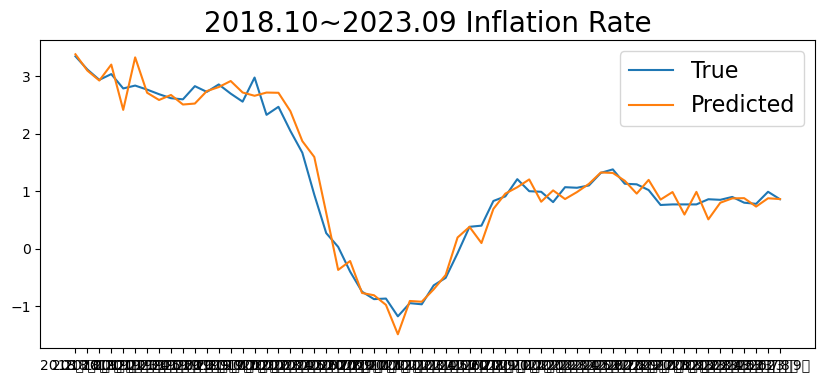

In [55]:
plt.figure(figsize=(10,4))
true, = plt.plot(df[-60:])
preds, = plt.plot(rolling_predictions)
plt.title('2018.10~2023.09 Inflation Rate', fontsize=20)
plt.legend(['True', 'Predicted'], fontsize=16)

In [56]:
mse=mean_squared_error(df[-60:], rolling_predictions)
print('Test MSE: %.4f' % mse)

Test MSE: 0.0444


In [57]:
rmse = sqrt(mse)
print('Test RMSE: %.4f' % rmse)

Test RMSE: 0.2107
